In [21]:
from enum import IntEnum
from typing import List
from gisim.classes.enums import ElementType,ReactionType

In [22]:
# 用来数据可视化的 没啥用
import itertools
import matplotlib.pyplot as plt

from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False


ell = {0:"-",1:"冻结",2:"融化",3:"超导",4:"结晶",5:"蒸发",6:"扩散", 7:"感电",8:"超载",9:"绽放",10:"燃烧",11:"激化"}

def imshow(data,title:bool=False):
    ax = plt.gca()
    ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)


    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    Label =  ["能否附着","冰","水","火","雷","岩","风","草"]
    ax.set_yticks(range(len(Label)))
    ax.set_yticklabels(Label)
    ax.set_xticks(range(len(Label)))
    ax.set_xticklabels(Label)
    for i, j in itertools.product(range(8), range(8)):
        if title:
            ort = data[i, j]
            if i == 0 and j == 0:
                t = "-"
            elif i == 0 or j == 0:
                t = "能" if ort == 0 else "不能"
            else:
                t = ell[ort]
            text = ax.text(j, i, t,
                        ha="center", va="center", color="k")
        else:
            text = ax.text(j, i, data[i, j],ha="center", va="center", color="k")
    plt.title("元素反应与元素附着",loc="left",pad=30)
    plt.imshow(data,cmap=plt.cm.Blues)
    plt.show()


In [23]:
import numpy as np

为了便捷判断元素是否可以参与反应，从而设计了一个8x8的二维矩阵。

第一行和第一列用于标识元素是否可以发生反应。矩阵的对角线没有任何意义。因为同种元素无法发生反应。

将该矩阵称为 RTE（Reaction Table for Element）。

In [24]:
RTE = np.zeros((8, 8), dtype="int")
RTE

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

使用 ["先手元素"],["后手元素"],反应类型 来初始化矩阵
比如，冻结。是水冰元素相遇。
```py
FROZEN = [ElementType.HYDRO], [ElementType.CRYO], ReactionType.FROZEN
```

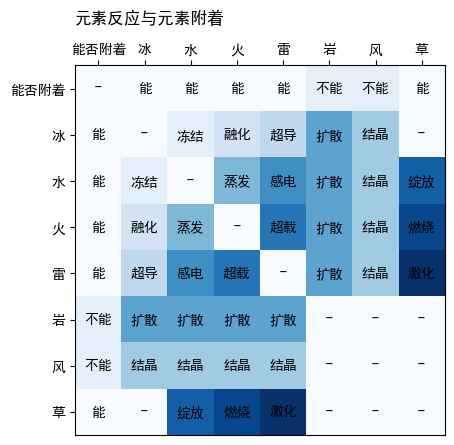

In [25]:
# 冻结
FROZEN_VAL = [ElementType.HYDRO], [ElementType.CRYO], ReactionType.FROZEN
# 融化
MELT_VAL = [ElementType.PYRO], [ElementType.CRYO], ReactionType.MELT
# 超导
SUPERCONDUCT_VAL = [ElementType.ELECTRO], [ElementType.CRYO], ReactionType.SUPERCONDUCT
# 蒸发
VAPORIZE_VAL = [ElementType.PYRO], [ElementType.HYDRO], ReactionType.VAPORIZE
# 感电
ELECTROCHARGED_VAL = [ElementType.ELECTRO], [ElementType.HYDRO], ReactionType.ELECTROCHARGED
# 超载
OVERLOADED_VAL = [ElementType.ELECTRO], [ElementType.PYRO], ReactionType.OVERLOADED
# 绽放
BLOOM_VAL = [ElementType.DENDRO], [ElementType.HYDRO], ReactionType.BLOOM
# 燃烧
BURNING_VAL = [ElementType.DENDRO], [ElementType.PYRO], ReactionType.BURNING
# 激化
QUICKEN_VAL = [ElementType.DENDRO], [ElementType.ELECTRO], ReactionType.QUICKEN
# 结晶
CRYSTALLIZE_VAL = [ElementType.GEO], [ElementType.CRYO, ElementType.HYDRO,ElementType.PYRO, ElementType.ELECTRO], ReactionType.CRYSTALLIZE
# 扩散
SWIRL_VAL = [ElementType.ANEMO], [ElementType.CRYO, ElementType.HYDRO,ElementType.PYRO, ElementType.ELECTRO], ReactionType.SWIRL
# 岩元素不可附着
ATTACHMENT_GEO_VAL = [ElementType.GEO], [0], 1
# 风元素不可附着
ATTACHMENT_ANEMO_VAL = [ElementType.ANEMO], [0], 1
ELEMENT_REACTION_MAP = [FROZEN_VAL, MELT_VAL, SUPERCONDUCT_VAL, VAPORIZE_VAL, ELECTROCHARGED_VAL, OVERLOADED_VAL, BLOOM_VAL, BURNING_VAL, QUICKEN_VAL, CRYSTALLIZE_VAL, SWIRL_VAL, ATTACHMENT_GEO_VAL, ATTACHMENT_ANEMO_VAL]


for row, col, val in ELEMENT_REACTION_MAP:
    RTE[np.ix_(row, col)] = val

RTE = RTE + RTE.T - np.diag(RTE.diagonal())
imshow(RTE,title = True)

In [26]:
def can_attachable(element: ElementType) -> bool:
    """是否为可附着元素 `True` 可附着"""
    attachment = RTE[np.ix_([element], [0])].tolist()
    return attachment[0][0] == 0


def sum_element_reaction(ElementalAttachment: List[ElementType], AddElement: ElementType) -> tuple[ReactionType, int]:
    """计算发生的元素反应"""
    # 根据表中的 以行为优先（附着的） 以列为后手元素 应该得到一个二维数组 1列 n行
    reaction = RTE[np.ix_(ElementalAttachment, [AddElement])]
    # 多元素反应
    reaction_dict = dict(enumerate(np.nditer(reaction), start=0))
    # 删掉不反应的 也就是为 0 的
    multiple_reaction = {key: value for key, value in reaction_dict.items() if value != 0}
    # 排序 越小优先级越高 越先反应
    multiple_reaction = sorted(multiple_reaction.items(), key=lambda x: x[1])
    if len(multiple_reaction) == 0:
        # 没有发生反应
        return ReactionType.NONE,0
    index, reaction_type = multiple_reaction[0]
    return ReactionType(reaction_type), index


def element_reaction(ElementalAttachment: List[ElementType], AddElement: ElementType) -> tuple[list, ReactionType]:
    if ElementType.GEO in ElementalAttachment or ElementType.ANEMO in ElementalAttachment:
        raise ValueError("There are non attachable elements in the attachment list")
    if AddElement in ElementalAttachment:
        # 挂已经附着的元素没有效果
        return ElementalAttachment, None
    attachable = can_attachable(AddElement)
    if not ElementalAttachment and attachable:
        # 如果角色没有元素附着，且新挂的元素是可附着元素
        ElementalAttachment.append(AddElement)
        return ElementalAttachment, None

    if not ElementalAttachment:
        # 如果角色没有元素附着，且新挂的元素是不可附着元素
        return ElementalAttachment, None
    # 判断元素反应
    reaction_type, index = sum_element_reaction(
        ElementalAttachment, AddElement)
    if reaction_type == ReactionType.NONE:
        if not attachable:
            return ElementalAttachment, None
        ElementalAttachment.append(AddElement)
        return ElementalAttachment, None
    # 发生了元素反应产生效果 获取效果
    ElementalAttachment.pop(index)
    return ElementalAttachment, reaction_type


<img src="https://githubimg.ngworks.cn/GeniusInvokationImg/GameScene/即将发生的元素反应.png_github" width="50%">

冰草水多元素反应。遵循下表规律，越靠左越优先反应。

In [27]:
#  冰 草 水反应
elemental_attachment: List[ElementType] = [ElementType.CRYO, ElementType.DENDRO]
dmg_element_type: ElementType = ElementType.HYDRO

print((["反应的后附着情况"],"触发的反应"))
element_reaction(elemental_attachment, dmg_element_type)

(['反应的后附着情况'], '触发的反应')


([<ElementType.DENDRO: 7>], <ReactionType.FROZEN: 1>)

In [28]:
elemental_attachment: List[ElementType] = [ElementType.DENDRO]
dmg_element_type = ElementType.CRYO

# 不能发生元素反应的
element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>, <ElementType.CRYO: 1>], None)

In [29]:
#重复挂元素的
elemental_attachment: List[ElementType] = [ElementType.DENDRO]
dmg_element_type = ElementType.DENDRO

element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>], None)

In [30]:
#燃烧
elemental_attachment: List[ElementType] = [ElementType.DENDRO]
dmg_element_type = ElementType.PYRO

element_reaction(elemental_attachment, dmg_element_type)

([], <ReactionType.BURNING: 10>)

In [31]:
#草 风不能发生反应 风也不能附着
elemental_attachment: List[ElementType] = [ElementType.DENDRO]
dmg_element_type = ElementType.ANEMO

element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>], None)

In [32]:
# 不能附着的
elemental_attachment: List[ElementType] = []
dmg_element_type = ElementType.ANEMO

element_reaction(elemental_attachment, dmg_element_type)

([], None)

In [33]:
# 多元素扩散
elemental_attachment: List[ElementType] = [ElementType.CRYO, ElementType.DENDRO]
dmg_element_type: ElementType = ElementType.ANEMO


element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>], <ReactionType.SWIRL: 6>)

In [34]:
# 多元素结晶
elemental_attachment: List[ElementType] = [ElementType.CRYO, ElementType.DENDRO]
dmg_element_type: ElementType = ElementType.GEO


element_reaction(elemental_attachment, dmg_element_type)

([<ElementType.DENDRO: 7>], <ReactionType.CRYSTALLIZE: 4>)

In [35]:
# 扩散
elemental_attachment: List[ElementType] = [ElementType.PYRO]
dmg_element_type: ElementType = ElementType.ANEMO


element_reaction(elemental_attachment, dmg_element_type)

([], <ReactionType.SWIRL: 6>)

In [36]:
# 结晶
elemental_attachment: List[ElementType] = [ElementType.ELECTRO]
dmg_element_type: ElementType = ElementType.GEO


element_reaction(elemental_attachment, dmg_element_type)

([], <ReactionType.CRYSTALLIZE: 4>)

In [37]:
# 输入有问题 比如告诉反应器 某角色附着了不可附着的元素
elemental_attachment: List[ElementType] = [ElementType.GEO]
dmg_element_type: ElementType = ElementType.ANEMO


# element_reaction(elemental_attachment, dmg_element_type)

也可以使用两个行向量内积，获得一个这样的矩阵。但是各种反应值的排列不是连续的。

In [38]:
# 原来的方法
RTE_ROW = np.arange(8).reshape(1,8)
RTE_COL = np.arange(8).reshape(8,1)

O__RTE = np.dot(RTE_COL,RTE_ROW)

In [39]:
# 原来的方法
CANNOTATTACHMENT = np.eye(8,dtype="bool")

# 冰 草 不反应
CORY_DENDRO = [ElementType.CRYO],[ElementType.DENDRO]
# 岩 不能和 草风反应
GEO_DENDRO_ANEMO = [ElementType.GEO],[ElementType.DENDRO,ElementType.ANEMO]
# 草 不能和 风反应
DENDRO_ANEMO = [ElementType.DENDRO],[ElementType.ANEMO]

CANNOTATTACHMENT_REACTION_MAP = [CORY_DENDRO,GEO_DENDRO_ANEMO,DENDRO_ANEMO]
for row, col in CANNOTATTACHMENT_REACTION_MAP:
    CANNOTATTACHMENT[np.ix_(row, col)] = val

# 先后手一样 对称一边就好
CANNOTATTACHMENT[CANNOTATTACHMENT.T] = True

CANNOTATTACHMENT

array([[ True, False, False, False, False, False, False, False],
       [False,  True, False, False, False, False, False,  True],
       [False, False,  True, False, False, False, False, False],
       [False, False, False,  True, False, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [False,  True, False, False, False,  True,  True,  True]])

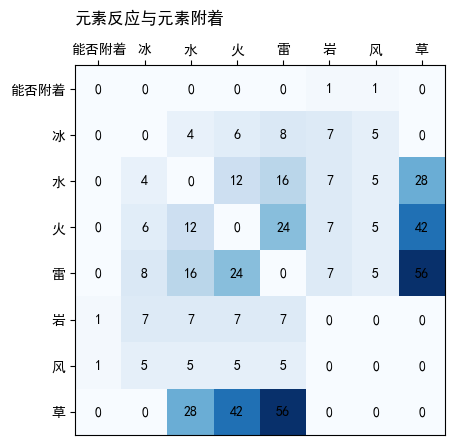

In [40]:
O__RTE[CANNOTATTACHMENT] = 0

# 结晶
CRYSTALLIZE_VAL = [ElementType.GEO], [ElementType.CRYO, ElementType.HYDRO,ElementType.PYRO, ElementType.ELECTRO], 5
# 扩散
SWIRL_VAL = [ElementType.ANEMO], [ElementType.CRYO, ElementType.HYDRO,ElementType.PYRO, ElementType.ELECTRO], 7
# 岩元素不可附着
ATTACHMENT_GEO_VAL = [ElementType.GEO], [0], 1
# 风元素不可附着

ELEMENT_REACTION_MAP = [CRYSTALLIZE_VAL, SWIRL_VAL, ATTACHMENT_GEO_VAL, ATTACHMENT_ANEMO_VAL]


for row, col, val in ELEMENT_REACTION_MAP:
    O__RTE[np.ix_(row, col)] = val

O__RTE[...,[ElementType.GEO,ElementType.ANEMO]] = 0

O__RTE = O__RTE + O__RTE.T - np.diag(O__RTE.diagonal())
imshow(O__RTE)